# DRIVE SAFE IN GENEVA


## Table of Contents
<p><div class="lev1"><a href="##1.-Project-planning"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Project planning</a></div>
 <div class="lev1"><a href="##2.-Understand-the-data"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Understand the data</a></div>
 </p>

## 1. Project planning
**Week 1** (1st nov - 8th Nov) : Understand the data

- Missing values
- Change the data formats
- Understand the categorical data
- Find distributions
- Correlations between the different features
- Find patterns
- Check for errors/dubious data

## 2. Understand the data

### 1.1. Libraries mport and  dataset load

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import folium

from pyproj import Proj, transform

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse

In [2]:
# Read the dataset
acc_data = 'Data/OTC_ACCIDENTS.csv'
compt_trafic_data = 'Data/OTC_COMPTAGE_TRAFIC.csv'
acc_df = pd.read_csv(acc_data, sep=';', encoding='latin-1')
compt_trafic_df = pd.read_csv(compt_trafic_data, sep=';', encoding='latin-1')

In [3]:
# Show the df to have a better idea
acc_df.head(3)

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,...,NB_MOTOS_50,NB_MOTOS_125,NB_MOTOS_11KW,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,E,N
0,876245.0,2010-11-30 00:00:00,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,2500774.0,1117364.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2500774.0,1117364.0
1,879408.0,2010-12-08 00:00:00,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,2498974.0,1118100.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2498974.0,1118100.0
2,877254.0,2010-12-02 00:00:00,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,2504618.0,1119635.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2504618.0,1119635.0


In [4]:
# Shape of the dataset
acc_df.shape

(19231, 35)

In [5]:
# Information of the dataset
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19231 entries, 0 to 19230
Data columns (total 35 columns):
ID_ACCIDENT              19231 non-null float64
DATE_                    19231 non-null object
GROUPE_ACCIDENT          19231 non-null object
CAUSE                    19231 non-null object
COMMUNE                  19231 non-null object
CONDITIONS_LUMINEUSES    19231 non-null object
CONDITIONS_METEO         19231 non-null object
CONSEQUENCES             19231 non-null object
COOR_X                   19231 non-null float64
COOR_Y                   19231 non-null float64
ETAT_ROUTE               19231 non-null object
GENRE_ROUTE              19231 non-null object
HEURE                    19230 non-null object
JOUR                     19231 non-null object
LOCALITE                 19231 non-null object
NB_ENFANTS_IMPLIQUES     19231 non-null float64
NB_ENFANTS_ECOLE         19231 non-null float64
NB_BLESSES_LEGERS        19231 non-null float64
NB_BLESSES_GRAVES        19231 non-null

The Geneva accidents dataset has 19'231 datapoints with 35 different features. They can be grouped in the following subgroups:

1) **Time**: DATE_, HEURE, JOUR

2) **Localisation**: COMMUNE, COOR_X, COOR_Y, LOCALITE, E, N 

3) **Conditions**: CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

4) **Accident type**: GROUPE_ACCIDENT, CAUSE 

5) **Number and type of people**: NB_ENFANTS_IMPLIQUES, NB_ENFANTS_ECOLE, NB_BLESSES_LEGERS, NB_BLESSES_GRAVES, NB_TUES, NB_PIETONS  

6) **Number of vehicles involved**: NB_BICYCLETTES, NB_VAE_25, NB_VAE_45, NB_CYCLOMOTEURS, NB_MOTOS_50, NB_MOTOS_125, NB_MOTOS_11KW, NB_VOITURES_TOURISME, NB_VOITURES_LIVRAISON, NB_CAMIONS, NB_BUS, NB_TRAM


### Plot helper functions


In [52]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        plot_name.text(p.get_x()+p.get_width()/2., height,'{:0.0f}'.format(height), ha="center").set_weight('bold')

def tick_format(plot,tick_type):
    if tick_type == 1:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
            label.set_rotation(90) 
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 2:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 3:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
            label.set_rotation(20)

### 1.1) Time

An important feature of the accidents datasets is the time: It answers the question when the accidents happen. This feature will be very useful for our further analysis. As time features, there are:
- Date
- Hour
- Day of the week

Let's check the format of this three features:

In [7]:
print(acc_df.DATE_.head(2))
print(acc_df.HEURE.head(2))
print(acc_df.JOUR.head(2))

0    2010-11-30 00:00:00
1    2010-12-08 00:00:00
Name: DATE_, dtype: object
0    1899-12-30 21:00:00
1    1899-12-30 14:00:00
Name: HEURE, dtype: object
0       Mardi
1    Mercredi
Name: JOUR, dtype: object


In order to use these features, we need to change the format. In addition, to enrich our analysis, we will create the `Year`, `Month` and `Day` of the month to find more correlations with the accidents:

In [8]:
# Datetime format
acc_df['DATE_'] = acc_df['DATE_'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))

# Create new time features
acc_df['YEAR'] = [date.year for date in acc_df['DATE_']]
acc_df['MONTH'] = [date.month for date in acc_df['DATE_']]
acc_df['DAY'] = [date.day for date in acc_df['DATE_']]
acc_df['HEURE'] = acc_df['HEURE'].fillna(acc_df['HEURE'].iloc[0])  # Fillna with first value of the df (Error neglible)
#acc_df.info()

Once the time data can be treated, we start our exploratory analysis by computing:
- Number of accidents per year
- Number of accidents per month
- Number of accidents per day of the month
- Number of accidents per weekday

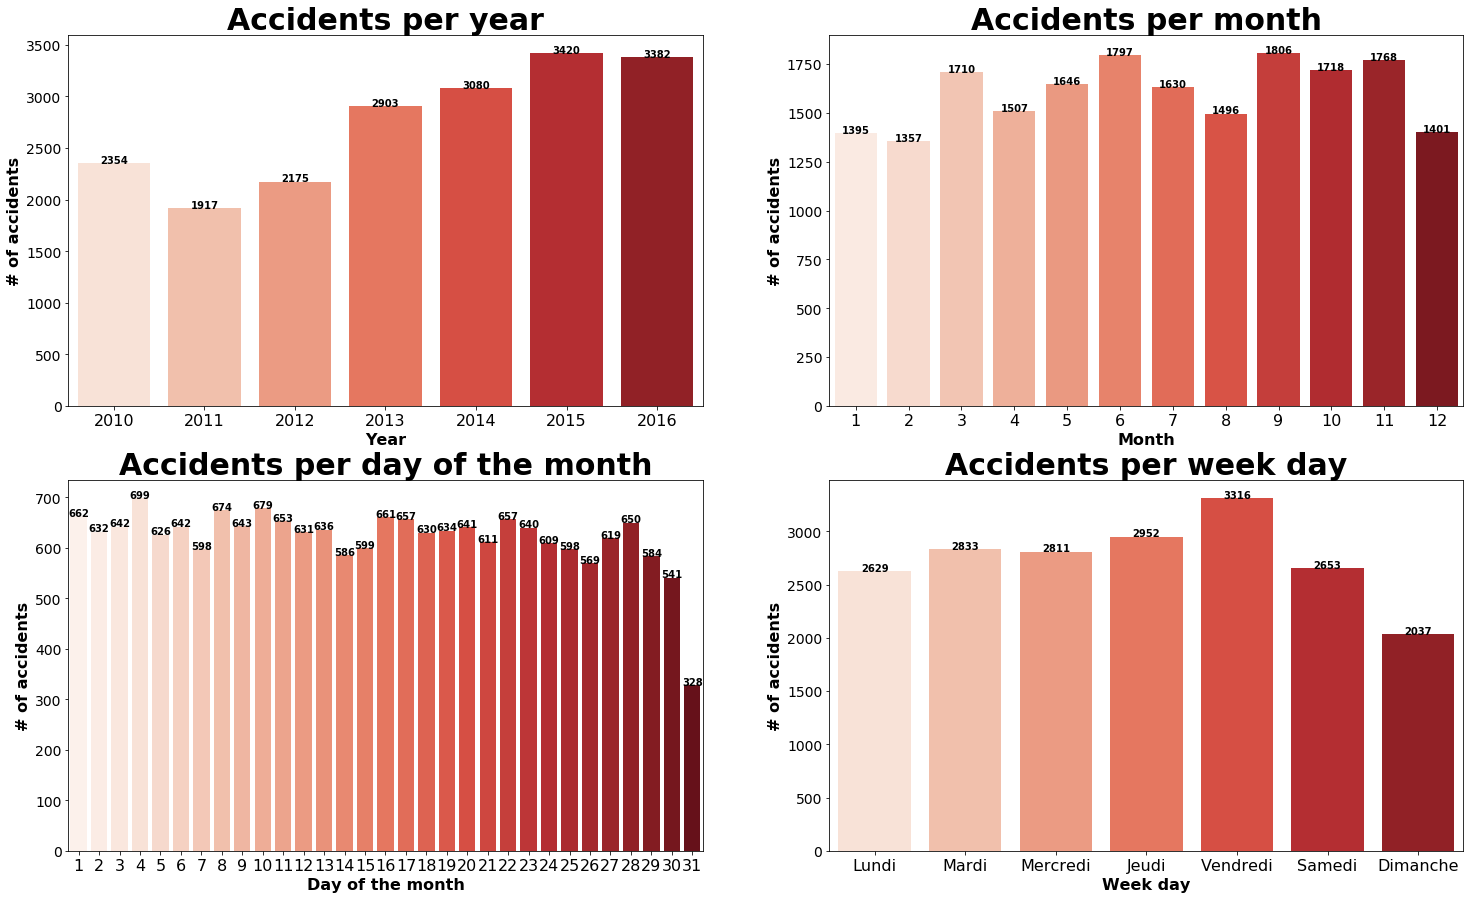

In [9]:
fig = plt.figure(figsize=(25,15))

# Visualize accidents per Year
ax1 = fig.add_subplot(221)
acc_per_year = acc_df.YEAR.value_counts(ascending=True, sort=False)
ax1 = sns.barplot(x=acc_per_year.index, 
                 y=acc_per_year, 
                 palette='Reds',
                 ax=ax1)
value_barplot_label(ax1)
plt.title("Accidents per year", fontsize=30).set_weight('bold')
tick_format(ax1, 2)
ax1.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax1.set_xlabel('Year', fontsize=16).set_weight('bold')


# Visualize accidents per month
ax2 = fig.add_subplot(222)
acc_per_month = acc_df.MONTH.value_counts(ascending=True, sort=False)
ax2 = sns.barplot(x=acc_per_month.index, 
                 y=acc_per_month, 
                 palette='Reds',
                 ax=ax2)
value_barplot_label(ax2)
plt.title("Accidents per month", fontsize=30).set_weight('bold')
tick_format(ax2, 2)
ax2.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax2.set_xlabel('Month', fontsize=16).set_weight('bold')

# Visualize accidents per day of the month
ax3 = fig.add_subplot(223)
acc_per_day = acc_df.DAY.value_counts(ascending=True, sort=False)
ax3 = sns.barplot(x=acc_per_day.index, 
                 y=acc_per_day, 
                 palette='Reds',
                 ax=ax3)
value_barplot_label(ax3)
plt.title("Accidents per day of the month", fontsize=30).set_weight('bold')
tick_format(ax3, 2)
ax3.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax3.set_xlabel('Day of the month', fontsize=16).set_weight('bold')

# Visualize accidents per weekday
ax4 = fig.add_subplot(224)
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_df.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds',
                 ax=ax4)
value_barplot_label(ax4)
plt.title("Accidents per week day", fontsize=30).set_weight('bold')
tick_format(ax4, 2)
ax4.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=16).set_weight('bold')

From the plots above we can draw some first conclusions of the time features:
- There is an observable increase of number of accidents between 2011 to 2015. In 2016, there is a neglegible decrease.
- During the year, it can be observed some up-downs. There is a peak of accidents in March, June, September, October and November. Our first guess is that during the months when it is the holidays start or the end of the year months, it is more probable to have an accident. A further analysis could be done in order to verify the first assumption by getting the information of the year holidays and seeing the correlation with the accidents dates. (**TO DEVELOP**).
- During the month, there is no appreciable correlation within the day of the month and the probability to have an accident
- However, during the week, the days with higher probability to have an accident are Thurstday and Friday. A further analysis can be to see if there is an increase of this tendency during the years (**TO DEVELOP**)


**Create a new feature of time of the day (morning, afternoon, evening, night)**

### 1.2) Localisation

An other important question to ask is WHERE?. The localisation features will help to answer this question and find the relation with the other features. 
As localisation features, we can find:
- **COOR_X**: X coordenate in 'epsg_2056' reference system
- **COOR_Y**: X coordenate in 'epsg_2056' reference system

E and N gives the same information as COOR_X and COOR_Y. This is why they will be dropped. The COOR_X and COOR_Y coordenates will be projected in the GPS coordenates, also called 'epsg:4326' reference system. For this, the Proj and transform libraries will be used:

In [10]:
# projection definition
p1 = Proj(init='epsg:2056')
p2 = Proj(init='epsg:4326')

# Helper functions
def coord_proj(acc_df,i, p1, p2):
    x1 = acc_df['COOR_X'].loc[i]
    y1 = acc_df['COOR_Y'].loc[i]
    x2, y2 = transform(p1,p2,x1,y1)
    acc_df['COOR_X'].set_value(i, x2)
    acc_df['COOR_Y'].set_value(i, y2)
    return acc_df

In [11]:
# Project data
for i in range(0, len(acc_df['COOR_X'])-1):
    acc_df = coord_proj(acc_df,i, p1, p2)
# Delete unuseful columns
#del acc_df['N']
#del acc_df['E']
acc_df.head(3)

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,CAUSE,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,...,NB_VOITURES_TOURISME,NB_VOITURES_LIVRAISON,NB_CAMIONS,NB_BUS,NB_TRAM,E,N,YEAR,MONTH,DAY
0,876245.0,2010-11-30,Dérapage ou perte de maîtrise,Inattention et distraction - Manque d'attentio...,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,...,1.0,0.0,0.0,0.0,0.0,2500774.0,1117364.0,2010,11,30
1,879408.0,2010-12-08,Autres,Utilisation inadéquate du véhicule - Stationne...,Genève,Jour,Beau,Autres,6.129641,46.206753,...,1.0,0.0,0.0,0.0,0.0,2498974.0,1118100.0,2010,12,8
2,877254.0,2010-12-02,Dérapage ou perte de maîtrise,Inobservation de signaux ou de la signalisatio...,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,...,1.0,0.0,0.0,0.0,0.0,2504618.0,1119635.0,2010,12,2


An other localisation feature is the "Commune". In order more information to get insight of the accidents dataset, it will be interesting to have the number of inhabitants of each Commune (**TO Develop**)

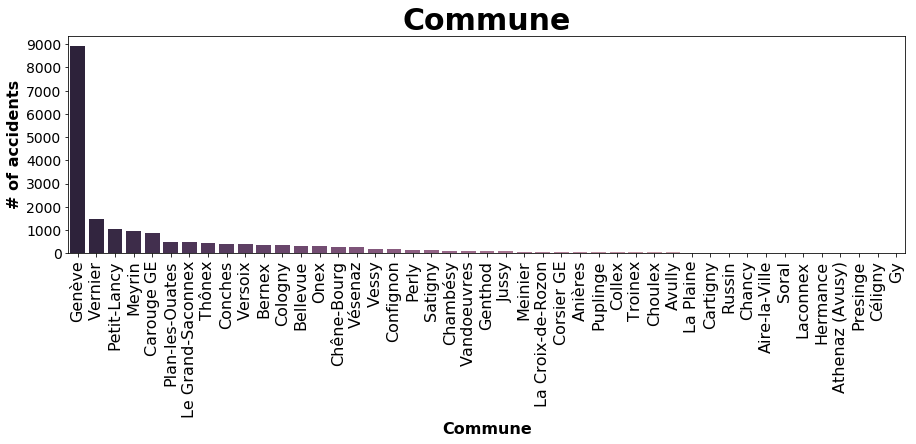

In [12]:

plt.figure(figsize=(15,4))
commune_accidents = acc_df.COMMUNE.value_counts()
ax = sns.barplot(x=commune_accidents.index, 
                 y=commune_accidents, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(commune_accidents.index)))
ax.set(yticks=np.linspace(0,9000,num=10))
plt.title("Commune", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax.set_xlabel('Commune', fontsize=16).set_weight('bold')

In [13]:
acc_df.LOCALITE.value_counts()

A l'intérieur d'une localité    10789
Non renseigné                    6101
A l'extérieur d'une localité     2341
Name: LOCALITE, dtype: int64

### 1.3) Conditions

In this section the external conditions of eacha ccidetn will be analysed. In the list of external conditions we can find:
- Light conditions
- Weather conditions
- Road conditions
- Road type
CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

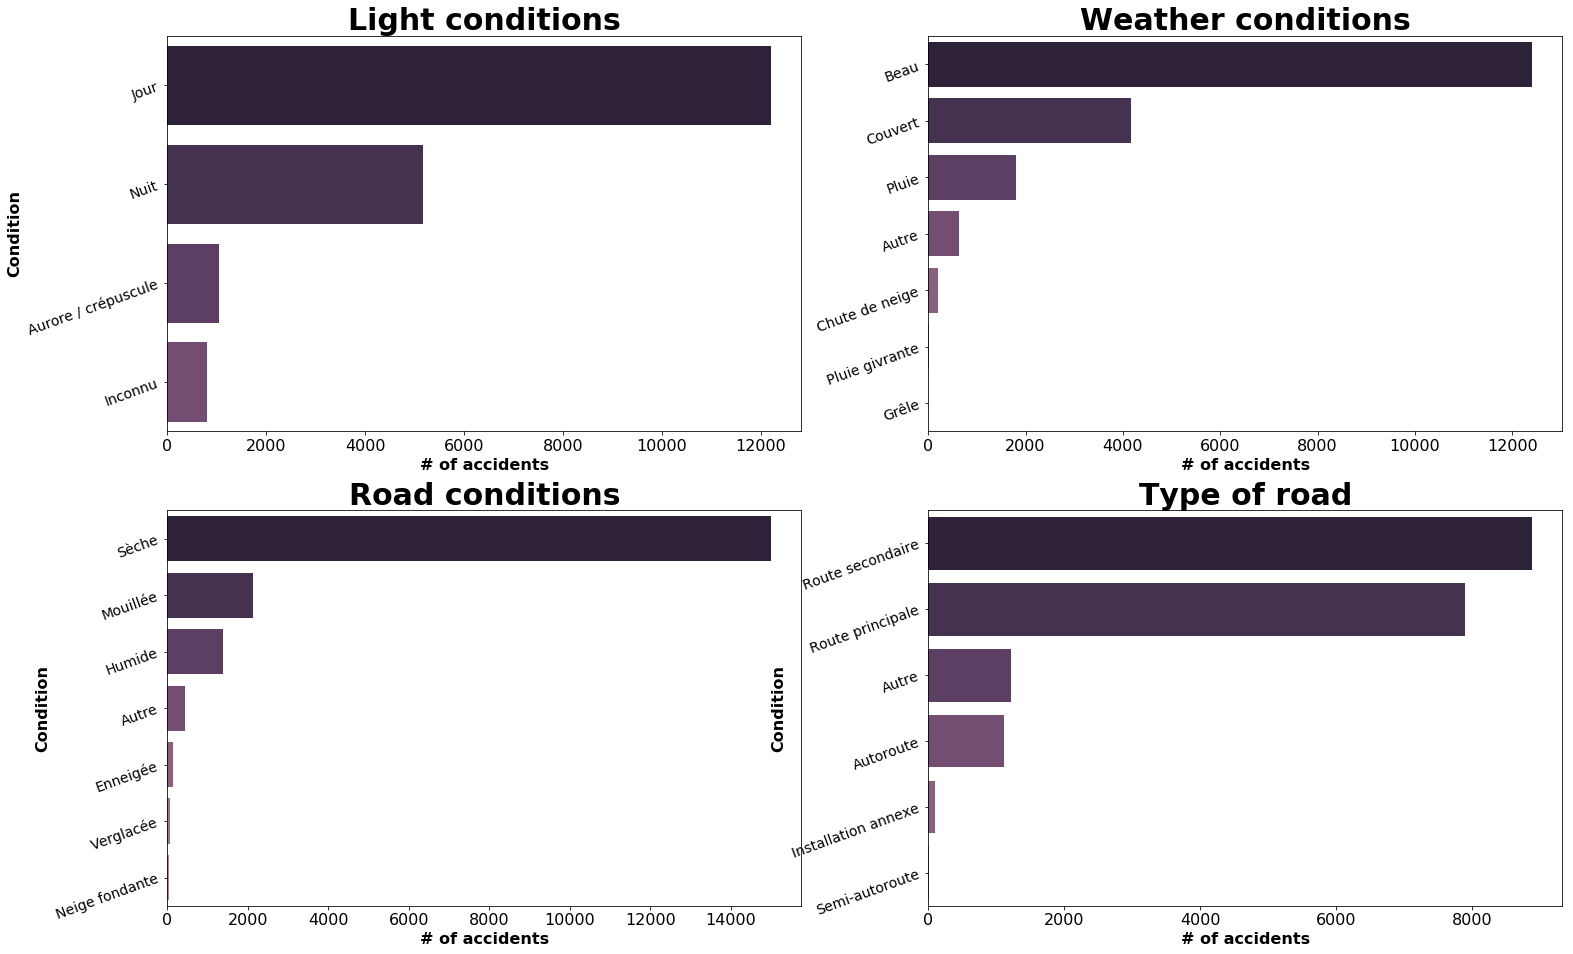

In [58]:
fig = plt.figure(figsize=(25,16))

# Visualize the accident group
ax1 = fig.add_subplot(221)
light_cond = acc_df.CONDITIONS_LUMINEUSES.value_counts()
ax1 = sns.barplot(x=light_cond, 
                 y=light_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)),
                 ax=ax1)
plt.title("Light conditions", fontsize=30).set_weight('bold')
tick_format(ax1, 3)
ax1.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax1.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax2 = fig.add_subplot(222)
weather_cond = acc_df.CONDITIONS_METEO.value_counts()
ax2 = sns.barplot(x=weather_cond, 
                 y=weather_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)),
                 ax=ax2)
plt.title("Weather conditions", fontsize=30).set_weight('bold')
tick_format(ax2, 3)
ax2.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax3 = fig.add_subplot(223)
road_cond = acc_df.ETAT_ROUTE.value_counts()
ax3 = sns.barplot(x=road_cond, 
                 y=road_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)),
                 ax=ax3)
plt.title("Road conditions", fontsize=30).set_weight('bold')
tick_format(ax3, 3)
ax3.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax3.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax4 = fig.add_subplot(224)
road_type = acc_df.GENRE_ROUTE.value_counts()
ax4 = sns.barplot(x=road_type, 
                 y=road_type.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)),
                 ax=ax4)
plt.title("Type of road", fontsize=30).set_weight('bold')
tick_format(ax4, 3)
ax4.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax4.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

### 1.1) Accident type

In the accident type features, it can be found:
- Accident group
- Causes

Let's start analysing the accident group.

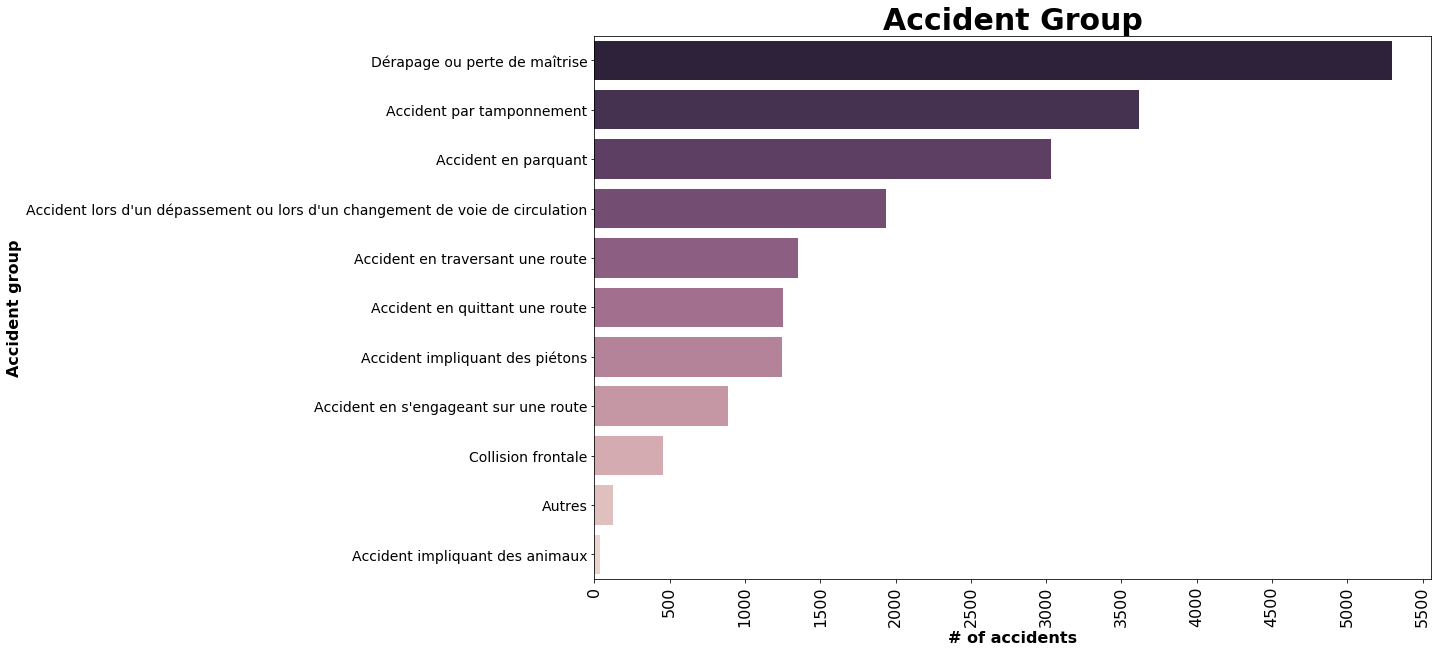

In [14]:
# Visualize the accident group
plt.figure(figsize=(15,10))
groupe_accidents = acc_df.GROUPE_ACCIDENT.value_counts()
ax = sns.barplot(x=groupe_accidents, 
                 y=groupe_accidents.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)))
ax.set(xticks=np.linspace(0,5500,num=12))
#value_barplot_label(ax)
plt.title("Accident Group", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Accident group', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

By the figure above, it can be identified that the accident groups with more accidents are:
- Dérapage ou perte de maîtrise
- Accident par tamponnement
- Accident en parquant

In [60]:
# Create a new df to treat the causes column
causes = acc_df[['CAUSE', 'GROUPE_ACCIDENT']]
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
del causes['GROUPE_ACCIDENT']

# Goal: To have only one "-" in order to split the causes into two columns, group and sugroup of causes
conflictive_txt = "(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)"
causes.CAUSE = causes.CAUSE.str.replace(conflictive_txt, "")
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
causes = causes.CAUSE.str.split(' - ', expand=True)
causes.rename(columns ={0: 'CAUSE_g', 1: 'CAUSE_sg'}, inplace=True)
acc_new = pd.concat([acc_df, causes], axis=1)
del acc_new['CAUSE']
acc_new.head(5)

/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/xaviergilcompanys/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,...,NB_CAMIONS,NB_BUS,NB_TRAM,E,N,YEAR,MONTH,DAY,CAUSE_g,CAUSE_sg
0,876245.0,2010-11-30,Dérapage ou perte de maîtrise,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,...,0.0,0.0,0.0,2500774.0,1117364.0,2010,11,30,Inattention et distraction,Manque d'attention momentané
1,879408.0,2010-12-08,Autres,Genève,Jour,Beau,Autres,6.129641,46.206753,Sèche,...,0.0,0.0,0.0,2498974.0,1118100.0,2010,12,8,Utilisation inadéquate du véhicule,Stationnement sans précautions suffisantes
2,877254.0,2010-12-02,Dérapage ou perte de maîtrise,Vandoeuvres,Jour,Couvert,Avec blessés légers,6.202445,46.221384,Enneigée,...,0.0,0.0,0.0,2504618.0,1119635.0,2010,12,2,Inobservation de signaux ou de la signalisation,Inobservation des règles de la circulation don...
3,857129.0,2010-10-16,Collision frontale,Cologny,Nuit,Couvert,Avec blessés graves,6.180094,46.208173,Humide,...,0.0,0.0,0.0,2502870.0,1118194.0,2010,10,16,Vitesse,"Inadaptée au tracé de la route (virage serré, ..."
4,843463.0,2010-09-17,Accident par tamponnement,Conches,Nuit,Pluie,Autres,6.174721,46.199584,Mouillée,...,0.0,0.0,0.0,2502440.0,1117246.0,2010,9,17,Inattention et distraction,Manque d'attention momentané


In [64]:
acc_new[acc_new.CAUSE_g == 'Inattention et distraction']


,ID_ACCIDENT,DATE_,GROUPE_ACCIDENT,COMMUNE,CONDITIONS_LUMINEUSES,CONDITIONS_METEO,CONSEQUENCES,COOR_X,COOR_Y,ETAT_ROUTE,...,NB_CAMIONS,NB_BUS,NB_TRAM,E,N,YEAR,MONTH,DAY,CAUSE_g,CAUSE_sg
0,876245.0,2010-11-30,Dérapage ou perte de maîtrise,Genève,Nuit,Chute de neige,Avec blessés légers,6.153116,46.200401,Enneigée,...,0.0,0.0,0.0,2500774.0,1117364.0,2010,11,30,Inattention et distraction,Manque d'attention momentané
4,843463.0,2010-09-17,Accident par tamponnement,Conches,Nuit,Pluie,Autres,6.174721,46.199584,Mouillée,...,0.0,0.0,0.0,2502440.0,1117246.0,2010,9,17,Inattention et distraction,Manque d'attention momentané
5,856554.0,2010-10-15,Dérapage ou perte de maîtrise,Cologny,Jour,Beau,Avec blessés graves,6.190697,46.232888,Sèche,...,0.0,0.0,0.0,2503732.0,1120928.0,2010,10,15,Inattention et distraction,Manque d'attention momentané
10,870305.0,2010-11-16,Accident en s'engageant sur une route,Genève,Jour,Pluie,Autres,6.159608,46.200376,Mouillée,...,0.0,0.0,0.0,2501275.0,1117353.0,2010,11,16,Inattention et distraction,Manque d'attention momentané
18,805589.0,2010-06-22,Dérapage ou perte de maîtrise,Genève,Jour,Beau,Avec blessés légers,6.147145,46.199784,Sèche,...,0.0,0.0,0.0,2500312.0,1117303.0,2010,6,22,Inattention et distraction,Manque d'attention momentané
25,849769.0,2010-09-30,Dérapage ou perte de maîtrise,Genève,Nuit,Couvert,Avec blessés légers,6.135122,46.211090,Mouillée,...,0.0,0.0,0.0,2499405.0,1118575.0,2010,9,30,Inattention et distraction,Manque d'attention momentané
30,806325.0,2010-06-23,Accident par tamponnement,Bernex,Jour,Beau,Autres,6.082385,46.186348,Sèche,...,0.0,0.0,0.0,2495288.0,1115894.0,2010,6,23,Inattention et distraction,Manque d'attention momentané
31,877571.0,2010-12-04,Dérapage ou perte de maîtrise,Genève,Nuit,Chute de neige,Autres,6.149662,46.209494,Enneigée,...,1.0,0.0,0.0,2500524.0,1118379.0,2010,12,4,Inattention et distraction,Manque d'attention momentané
32,873084.0,2010-11-23,Dérapage ou perte de maîtrise,Onex,Jour,Pluie,Avec blessés légers,6.106134,46.187728,Humide,...,0.0,0.0,0.0,2497124.0,1116016.0,2010,11,23,Inattention et distraction,Manque d'attention momentané
38,837979.0,2010-09-03,Dérapage ou perte de maîtrise,Meyrin,Nuit,Beau,Avec blessés légers,6.078205,46.230247,Sèche,...,0.0,0.0,0.0,2495050.0,1120779.0,2010,9,3,Inattention et distraction,Manque d'attention momentané


Utilisation inadéquate du véhicule
    - Manoeuvres incorrectes dans le véhicule ():
        -(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)

In [21]:
# Create the map visualization
Geneve_coord = [46.2004013, 6.1531163]
m = folium.Map(location=Geneve_coord,
               tiles='OpenStreetMap',
               zoom_start=10)

In [75]:

for i in range(0, len(acc_df['COOR_X'].head(10))):
    folium.Marker([acc_df.COOR_Y.loc[i], acc_df.COOR_X.loc[i]] , popup="1").add_to(m)

KeyError: 'the label [2] is not in the [index]'

In [73]:
acc_df[acc_df.COMMUNE == 'Genève'].COOR_Y

0        46.200401
1        46.206753
6        46.194382
7        46.211643
9        46.219988
10       46.200376
12       46.195613
15       46.197151
17       46.201537
18       46.199784
20       46.220468
25       46.211090
26       46.190109
27       46.201642
28       46.212423
31       46.209494
35       46.209398
39       46.201741
40       46.189333
42       46.211065
44       46.198766
47       46.201426
51       46.208757
52       46.201328
53       46.200725
54       46.206985
55       46.194798
57       46.188522
58       46.201492
59       46.214397
           ...    
19161    46.199094
19162    46.215776
19163    46.200613
19169    46.191395
19175    46.199651
19176    46.199560
19177    46.198972
19178    46.216699
19179    46.204614
19180    46.206856
19182    46.201354
19186    46.202403
19187    46.209425
19188    46.206998
19201    46.198247
19203    46.193654
19205    46.191785
19208    46.208788
19209    46.203668
19211    46.208003
19213    46.181782
19217    46.

Ideas:
* For each accident zone personalize the information panels